In [1]:
import torch
from torch.autograd import Variable

## custom dataloaders
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
from networks import EmbeddingNet, TripletNet, SiameseNet, LeNet

import matplotlib
import matplotlib.pyplot as plt

import time

import numpy as np

First, we need to make sure that discriminator can differenciate between Real and Fake samples in Embedding space rather than whole image space. In other words, we need to define three mappings as follows :-

$$ D : \mathcal{R}^{z} \rightarrow \mathcal{R}^{p} $$
$$ \theta : \mathcal{R}^{p} \rightarrow \mathcal{R}^{c} $$
$$ G : \mathcal{R}^{c} \rightarrow \{0,1\}$$

GAN with fully convolutional generator and densely connected discriminator. Siamese domain embedding to map primary and helper class instances to common subspace

$$ \theta : \mathcal{R}^{p} \rightarrow \mathcal{R}^{c}$$
$$ \phi : \mathcal{R}^{h} \rightarrow \mathcal{R}^{c}$$

Instead of vanilla GAN setting where discriminator and generator van represented as the following functions :-

$$ G :\mathcal{R}^{z} \rightarrow \mathcal{R}^{p} $$
$$ D :\mathcal{R}^{p} \rightarrow \left\{ 0,1 \right\} $$

our framework, called Siamese GAN, incorporates these as the following functions :-

$$ G :\mathcal{R}^{z} \rightarrow \mathcal{R}^{p} $$
$$ D : \boldsymbol{\mathcal{R}^{c}} \rightarrow \left\{0,1 \right\} $$


In [2]:
# first load the generator and discriminator models
from model_C_Lenet import Generator, Discriminator

In [3]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda=1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = TripletNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'triplet'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))
print model

TripletNet (
  (embedding_net_1): LeNet (
    (convnet): Sequential (
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU ()
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU ()
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (400 -> 120)
      (1): ReLU ()
      (2): Linear (120 -> 84)
    )
  )
  (embedding_net_2): LeNet (
    (convnet): Sequential (
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU ()
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU ()
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (400 -> 120)
      (1): ReLU ()
      (2): Linear (120 -> 84)
    )
  )
)


In [4]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

<img src="./images/embedding_GAN.png"  >


In [5]:
batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64
numPrimaryOutputChannels = getChannels(primaryDataset)
numHelperOutputChannels = getChannels(helperDataset)

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

In [9]:
G = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
D = Discriminator(numClasses)

#initialize weights 
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

# take the binary cross entropy loss 
lossFunction = nn.BCELoss()

genOptimizer = optim.Adam(G.parameters(),
                          lr=learningRate,
                          betas = (0.5,0.999))
discOptimizer = optim.Adam(D.parameters(),
                           lr=learningRate,
                           betas = (0.5,0.999))

In [10]:
classes = [i for i in range(10)]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')
trainDatasetHelper = loadDataset(helperDataset, classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')
testDatasetHelper = loadDataset(helperDataset, classes, instances, 'test' )

primayTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)
helperTrainLoader = torch.utils.data.DataLoader(trainDatasetHelper, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primayTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)
helperTestLoader = torch.utils.data.DataLoader(testDatasetHelper, batch_size=batchSize, shuffle=True, **kwargs)

In [19]:
# train using the primary class only 

def train(primaryTrainLoader,
          helperTrainLoader,
          primaryClassFlag = True,
          helperClassFlag = True,
          learningRate = 0.0002,
          epochs=20):
    
    G = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    D = Discriminator(numClasses)

    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)

    # define loss function and optimizers
    lossFunction = nn.BCELoss()

    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator pertaining primary class
    discRealInputPrimary = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    
    # real input to the discriminator
    discRealInputHelper = torch.FloatTensor(batchSize,
                                      numHelperOutputChannels,
                                      imageSize,
                                      imageSize)
    
    # label is 1 for real examples and 0 for generated examples
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numNoiseChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInputPrimary = discRealInputPrimary.cuda()
        discRealInputHelper = discRealInputHelper.cuda()
        
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # train using theta - the embedding of primary class only
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        primaryEpochstartTime = time.time()
        
        if primaryClassFlag:
            for i,data in enumerate(primaryTrainLoader, 0):

                # train discriminator D

                # set the gradients in computation graph of discriminator to be 0
                D.zero_grad()
                dataInstance, dataClass = data

                # one-hot encoding for discriminator class input
                dataClass = oneHotDisc[dataClass]

                if cuda:
                    dataInstance = dataInstance.cuda()
                    dataClass = dataClass.cuda()


                #print discRealInputPrimary.shape, dataInstance.shape

                # train discriminator on real classes
                discRealInputPrimary.copy_(dataInstance)
                discRealInputClass.copy_(dataClass)

                discRealInputPrimaryV = Variable(discRealInputPrimary)
                discRealInputClassV = Variable(discRealInputClass)
                discRealLabelV = Variable(discRealLabel)


                ## given embedding of the real data instead of image to disceriminator
                ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
                #print discRealInputV
                discRealInputEmbedding = model.get_embedding(discRealInputPrimaryV, 'primary')

                discRealOutput = D(discRealInputEmbedding,
                                   discRealInputClassV)


                discLossReal = lossFunction(discRealOutput,
                                            discRealLabelV)

                # calculate the gradients for nodes of computation graph
                discLossReal.backward()

                # train discriminator on fake classes
                #  p=getProbDist(primaryInstanceList)
                dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
                discFakeInputClass = oneHotDisc[dataFakeClass]
                genFakeInputClass = oneHotGen[dataFakeClass]

                if cuda:
                    discFakeInputClass = discFakeInputClass.cuda()
                    genFakeInputClass = genFakeInputClass.cuda()


                discFakeInput.normal_(0,1)

                discFakeInputClassV= Variable(discFakeInputClass)
                genFakeInputClassV = Variable(genFakeInputClass)
                discFakeInputV = Variable(discFakeInput)
                discFakeLabelV = Variable(discFakeLabel)


                genFakeOutput = G(discFakeInputV,
                                  genFakeInputClassV)
                #genFakeOutput = genFakeOutput.view(batchSize,-1)

                # get the 84 dimensional embedding of generator output
                genFakeOutputEmbedding = model.get_embedding(genFakeOutput, 'primary')

                # detach the graph prior to D. So what weights in G do not get updated
                #print genFakeOutput.data.shape, discFakeInputClassV.data.shape

                discFakeOutput = D(genFakeOutputEmbedding.detach(),
                                   discFakeInputClassV)

                discLossFake = lossFunction(discFakeOutput,
                                            discFakeLabelV)

                # calculate the gradients for nodes of computation graph
                discLossFake.backward()

                # log the loss for discriminator
                discriminatorLosses.append((discLossReal+discLossFake).data[0])

                # update the weights
                discOptimizer.step()

                # train generator with discriminator feedback
                G.zero_grad()


                # have to freeze weights of theta
                discFakeOutput = D(genFakeOutputEmbedding,
                                   discFakeInputClassV)

                genLossFake = lossFunction(discFakeOutput, 
                                           discRealLabelV)

                genLossFake.backward()
                genOptimizer.step()

                # log the loss for generator
                generatorLosses.append(genLossFake.data[0])
        
        if helperClassFlag:
            ### training with helper class
            for i,data in enumerate(helperTrainLoader, 0):

                # train discriminator D

                # set the gradients in computation graph of discriminator to be 0
                D.zero_grad()
                dataInstance, dataClass = data

                # one-hot encoding for discriminator class input
                dataClass = oneHotDisc[dataClass]

                if cuda:
                    dataInstance = dataInstance.cuda()
                    dataClass = dataClass.cuda()


                #print discRealInput.shape, dataInstance.shape

                # train discriminator on real classes
                discRealInputHelper.copy_(dataInstance)
                discRealInputClass.copy_(dataClass)

                discRealInputHelperV = Variable(discRealInputHelper)
                discRealInputClassV = Variable(discRealInputClass)
                discRealLabelV = Variable(discRealLabel)


                ## given embedding of the real data instead of image to disceriminator
                ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
                #print discRealInputV
                discRealInputEmbedding = model.get_embedding(discRealInputHelperV, 'helper')

                discRealOutput = D(discRealInputEmbedding,
                                   discRealInputClassV)


                discLossReal = lossFunction(discRealOutput,
                                            discRealLabelV)

                # calculate the gradients for nodes of computation graph
                discLossReal.backward()

                # train discriminator on fake classes
                #  p=getProbDist(primaryInstanceList)
                dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
                discFakeInputClass = oneHotDisc[dataFakeClass]
                genFakeInputClass = oneHotGen[dataFakeClass]

                if cuda:
                    discFakeInputClass = discFakeInputClass.cuda()
                    genFakeInputClass = genFakeInputClass.cuda()


                discFakeInput.normal_(0,1)

                discFakeInputClassV= Variable(discFakeInputClass)
                genFakeInputClassV = Variable(genFakeInputClass)
                discFakeInputV = Variable(discFakeInput)
                discFakeLabelV = Variable(discFakeLabel)


                genFakeOutput = G(discFakeInputV,
                                  genFakeInputClassV)
                #genFakeOutput = genFakeOutput.view(batchSize,-1)

                # get the 84 dimensional embedding of generator output
                genFakeOutputEmbedding = model.get_embedding(genFakeOutput, 'primary')

                # detach the graph prior to D. So what weights in G do not get updated
                #print genFakeOutput.data.shape, discFakeInputClassV.data.shape

                discFakeOutput = D(genFakeOutputEmbedding.detach(),
                                   discFakeInputClassV)

                discLossFake = lossFunction(discFakeOutput,
                                            discFakeLabelV)

                # calculate the gradients for nodes of computation graph
                discLossFake.backward()

                # log the loss for discriminator
                discriminatorLosses.append((discLossReal+discLossFake).data[0])

                # update the weights
                discOptimizer.step()

                # train generator with discriminator feedback
                G.zero_grad()


                # have to freeze weights of theta
                discFakeOutput = D(genFakeOutputEmbedding,
                                   discFakeInputClassV)

                genLossFake = lossFunction(discFakeOutput, 
                                           discRealLabelV)

                genLossFake.backward()
                genOptimizer.step()

                # log the loss for generator
                generatorLosses.append(genLossFake.data[0])



        epochEndTime = time.time()
        perEpochTime = epochEndTime - primaryEpochstartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    
    
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

Epoch : [1/20] time: 30.26, loss_d: 1.373, loss_g: 0.709
Epoch : [2/20] time: 33.19, loss_d: 1.382, loss_g: 0.696
Epoch : [3/20] time: 33.23, loss_d: 1.377, loss_g: 0.701
Epoch : [4/20] time: 33.19, loss_d: 1.353, loss_g: 0.717
Epoch : [5/20] time: 33.16, loss_d: 1.314, loss_g: 0.745
Epoch : [6/20] time: 33.20, loss_d: 1.250, loss_g: 0.796
Epoch : [7/20] time: 33.20, loss_d: 1.185, loss_g: 0.852
Epoch : [8/20] time: 33.16, loss_d: 1.150, loss_g: 0.893
Epoch : [9/20] time: 33.16, loss_d: 1.039, loss_g: 1.006
Epoch : [10/20] time: 33.16, loss_d: 1.016, loss_g: 1.050
Epoch : [11/20] time: 33.18, loss_d: 0.989, loss_g: 1.111
Epoch : [12/20] time: 33.19, loss_d: 0.974, loss_g: 1.160
Epoch : [13/20] time: 33.13, loss_d: 0.915, loss_g: 1.233
Epoch : [14/20] time: 33.15, loss_d: 0.892, loss_g: 1.287
Epoch : [15/20] time: 33.15, loss_d: 0.885, loss_g: 1.342
Epoch : [16/20] time: 33.14, loss_d: 0.856, loss_g: 1.393
Epoch : [17/20] time: 33.18, loss_d: 0.835, loss_g: 1.485
Epoch : [18/20] time: 3

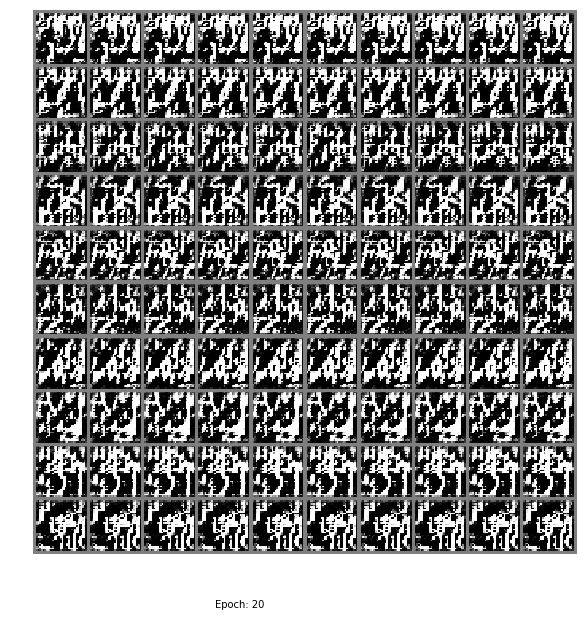

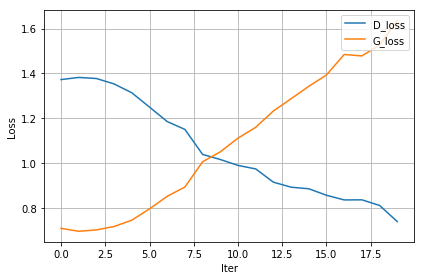

In [16]:
train(primayTrainLoader, helperTrainLoader, epochs=20)

Now we need to train with the helper dataset

Epoch : [1/40] time: 14.30, loss_d: 1.373, loss_g: 0.704
Epoch : [2/40] time: 14.39, loss_d: 1.386, loss_g: 0.695
Epoch : [3/40] time: 14.56, loss_d: 1.387, loss_g: 0.694
Epoch : [4/40] time: 15.63, loss_d: 1.386, loss_g: 0.694
Epoch : [5/40] time: 16.34, loss_d: 1.387, loss_g: 0.693
Epoch : [6/40] time: 16.34, loss_d: 1.387, loss_g: 0.693
Epoch : [7/40] time: 16.35, loss_d: 1.386, loss_g: 0.694
Epoch : [8/40] time: 16.34, loss_d: 1.386, loss_g: 0.694
Epoch : [9/40] time: 16.34, loss_d: 1.385, loss_g: 0.694
Epoch : [10/40] time: 16.35, loss_d: 1.385, loss_g: 0.694
Epoch : [11/40] time: 16.33, loss_d: 1.385, loss_g: 0.694
Epoch : [12/40] time: 16.34, loss_d: 1.384, loss_g: 0.695
Epoch : [13/40] time: 16.34, loss_d: 1.384, loss_g: 0.694
Epoch : [14/40] time: 16.34, loss_d: 1.384, loss_g: 0.695
Epoch : [15/40] time: 16.34, loss_d: 1.384, loss_g: 0.695
Epoch : [16/40] time: 16.33, loss_d: 1.383, loss_g: 0.695
Epoch : [17/40] time: 16.33, loss_d: 1.382, loss_g: 0.695
Epoch : [18/40] time: 1

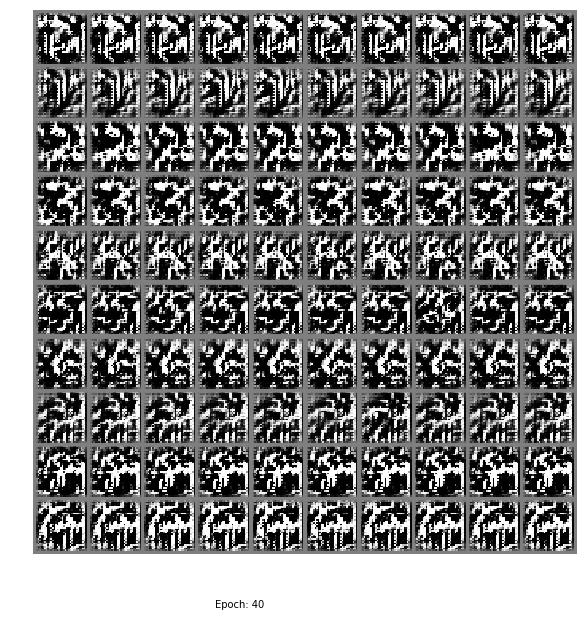

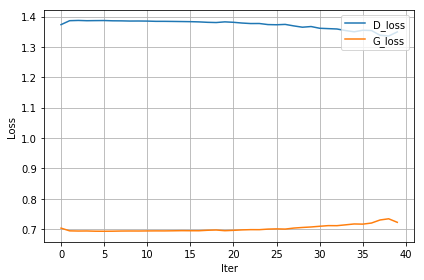

In [21]:
train(primayTrainLoader, helperTrainLoader, helperClassFlag=False, epochs=40)

Epoch : [1/40] time: 16.89, loss_d: 1.384, loss_g: 0.707
Epoch : [2/40] time: 16.88, loss_d: 1.376, loss_g: 0.702
Epoch : [3/40] time: 16.92, loss_d: 1.339, loss_g: 0.724
Epoch : [4/40] time: 16.87, loss_d: 1.274, loss_g: 0.764
Epoch : [5/40] time: 16.90, loss_d: 1.208, loss_g: 0.803
Epoch : [6/40] time: 16.88, loss_d: 1.118, loss_g: 0.864
Epoch : [7/40] time: 16.88, loss_d: 1.000, loss_g: 0.953
Epoch : [8/40] time: 16.86, loss_d: 0.884, loss_g: 1.057
Epoch : [9/40] time: 16.88, loss_d: 0.751, loss_g: 1.179
Epoch : [10/40] time: 16.91, loss_d: 0.679, loss_g: 1.282
Epoch : [11/40] time: 16.87, loss_d: 0.571, loss_g: 1.431
Epoch : [12/40] time: 16.86, loss_d: 0.485, loss_g: 1.566
Epoch : [13/40] time: 16.88, loss_d: 0.414, loss_g: 1.721
Epoch : [14/40] time: 16.88, loss_d: 0.371, loss_g: 1.827
Epoch : [15/40] time: 16.86, loss_d: 0.314, loss_g: 1.980
Epoch : [16/40] time: 16.90, loss_d: 0.267, loss_g: 2.137
Epoch : [17/40] time: 16.90, loss_d: 0.225, loss_g: 2.305
Epoch : [18/40] time: 1

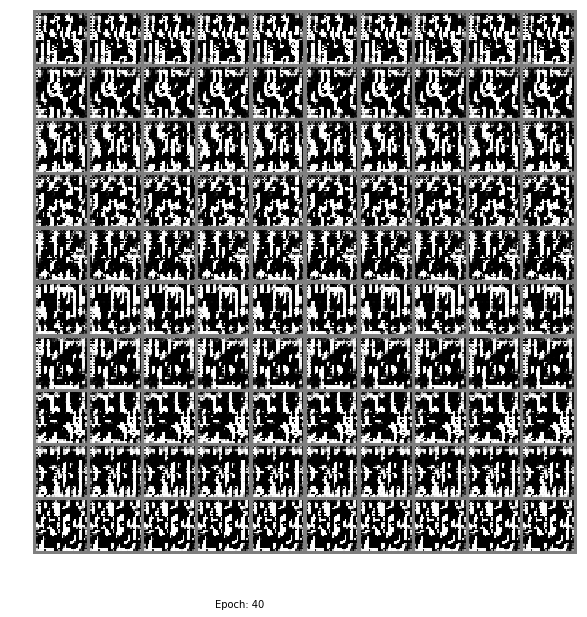

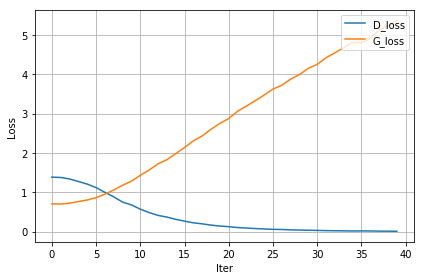

In [22]:
train(primayTrainLoader, helperTrainLoader, primaryClassFlag=False, epochs=40)